In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from collections import defaultdict, OrderedDict, Counter
import copy
import time
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import date, datetime
import uuid
import os
from PIL import Image
import io
import pickle

from ventricle_segmentation.utils import plot_annotated_scan, make_sure_path_exists, pickle_dump, print_info, iou, get_pixel_intensities
from ventricle_segmentation.parsing import load_all_scans
import ventricle_segmentation.cfg as cfg

Populating the interactive namespace from numpy and matplotlib


# Pixel intensities - blood pool / heart muscle
Let’s assume that you want to create a system to outline the boundary of the blood pool (i-contours), and you already know the outer border of the heart muscle (o-contours). Compare the differences in pixel intensities inside the blood pool (inside the i-contour) to those inside the heart muscle (between the i-contours and o-contours); could you use a simple thresholding scheme to automatically create the i-contours, given the o-contours? Why or why not? Show figures that help justify your answer.

First we load the data, filter out scans without o-contours and split the data into dev/test set. Dev set might be used to set some hyperparameters, test set to verify results.

In [2]:
n = None

scans = list(load_all_scans(cfg.LINKS_FILE, cfg.DICOMS_DIR, cfg.CONTOURS_DIR, n=n))
print("Nr scans", len(scans))

scans = [scan for scan in scans if scan.omask is not None]
print("Nr scans with o-mask", len(scans))

split = int(len(scans)/2)
scans_dev, scans_test = scans[:split], scans[split:]
print("Nr scans dev", len(scans_dev))
print("Nr scans test", len(scans_test))

Nr scans 74
Nr scans with o-mask 37
Nr scans dev 18
Nr scans test 19


First we define some plotting functions

In [3]:
def plot_pixel_intensities_hist(scans, norm_scan_intenities):
    blod_pool_intensities, heart_muscle_inteneities = get_pixel_intensities(scans, norm_scan_intenities)
    plt.figure(figsize=(14, 8))
    plt.hist([blod_pool_intensities, heart_muscle_inteneities], normed=True, bins=100)
    plt.legend(["blood pool", "heart muscle"])
    plt.xlabel("pixel intensity")
    norm_scan_intenities_txt = "normed" if norm_scan_intenities else ""
    plt.title("Hisotgram of pixel intensities " + norm_scan_intenities_txt)

We can plot histogram of pixel intensities of blood pool and heart muscle to see if we can use simple thresholding for 
blood pull segmentation based on we know the o-contour (outer controu of heart muscle).

If pixel intenisites histograms are separated, it would be possible to use thresholding.

/home/prinda/.pyenv/versions/3.6.4/envs/pyArterys/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


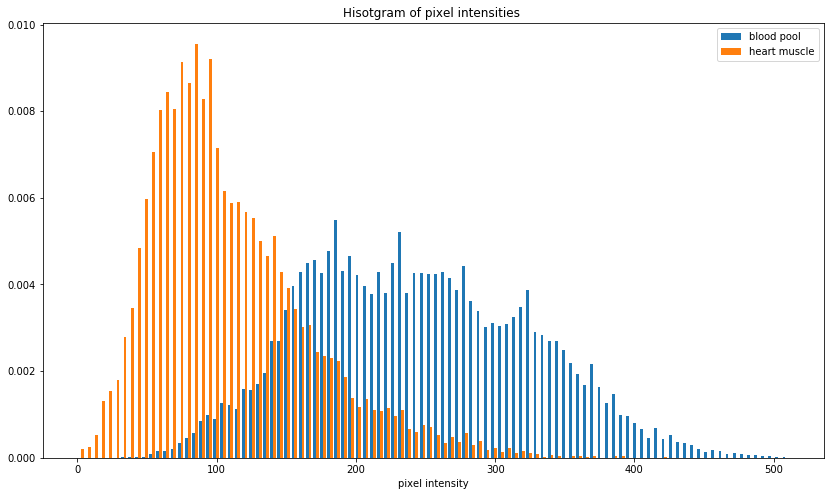

In [4]:
plot_pixel_intensities_hist(scans_dev, norm_scan_intenities=False)

Doesn't look very well.

But we can scale each scan so that pixels inside o-contour are between <0, 1>

/home/prinda/.pyenv/versions/3.6.4/envs/pyArterys/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


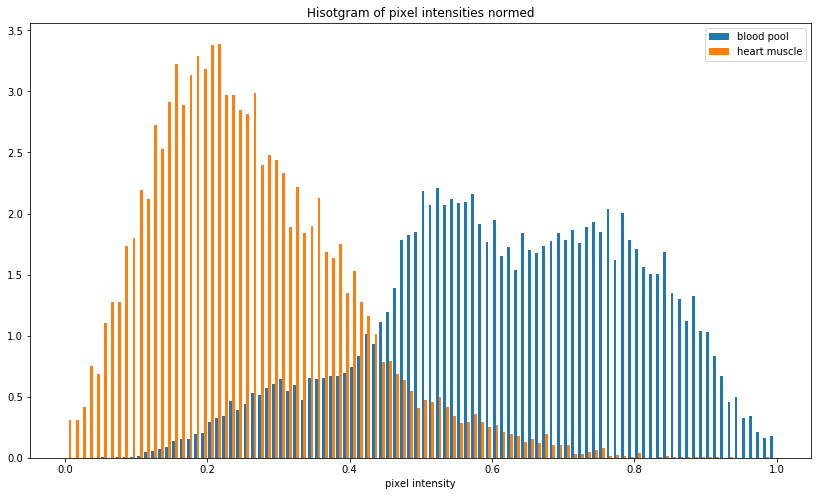

In [5]:
plot_pixel_intensities_hist(scans_dev, norm_scan_intenities=True)

It's hard to say if it's better just from the graph so we can use thresholding, calculate some metrics and plot thresholding results.

# Thresholding

First we define metric interstion over union 

In [6]:
def iou_scan(scan):
    return iou(scan.imask.mask, scan.imask_prediction)

def measure_method(scans, th_method, **args):
    
    # Use method
    for scan in scans:
        scan.imask_prediction = th_method(scan, **args)

    # Calculate score
    scores = [iou_scan(scan) for scan in scans]
    print("Mean score: ", mean(scores))
    
    # Plot best and worst results
    scan_scores = sorted(zip(scans, scores), key=lambda x: x[1])
    worst_scan, worst2_scan, best_scan = scan_scores[0][0], scan_scores[1][0], scan_scores[-1][0]
    
    plot_annotated_scan(worst_scan, plot_imask=False, plot_omask=False, plot_imask_pred=False, title="Worst scan")
    plot_annotated_scan(worst_scan, plot_imask=True, plot_omask=False, plot_imask_pred=True, title="Worst scan")
    
    plot_annotated_scan(worst2_scan, plot_imask=False, plot_omask=False, plot_imask_pred=False, title="2nd Worst scan")
    plot_annotated_scan(worst2_scan, plot_imask=True, plot_omask=False, plot_imask_pred=True, title="2nd Worst scan")
    
    plot_annotated_scan(best_scan, plot_imask=False, plot_omask=False, plot_imask_pred=False,  title="Best scan")
    plot_annotated_scan(best_scan, plot_imask=True, plot_omask=False, plot_imask_pred=True,  title="Best scan")
    
    
    return scores

## Thresholding simple

First we can try naive basline where we take absolute value of an image as a threshold for all images. We take threshold value from the plot above.

Mean score:  0.6048874732704425


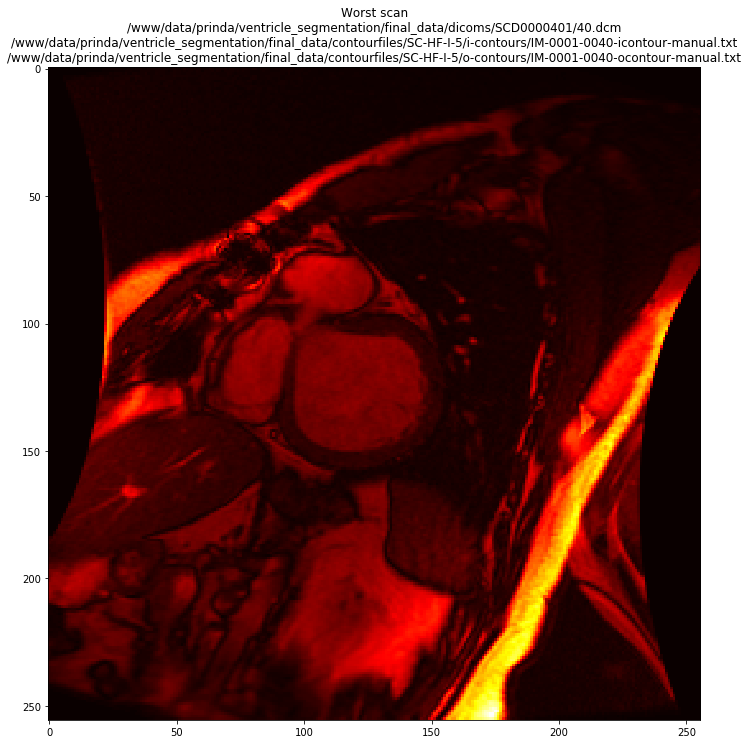

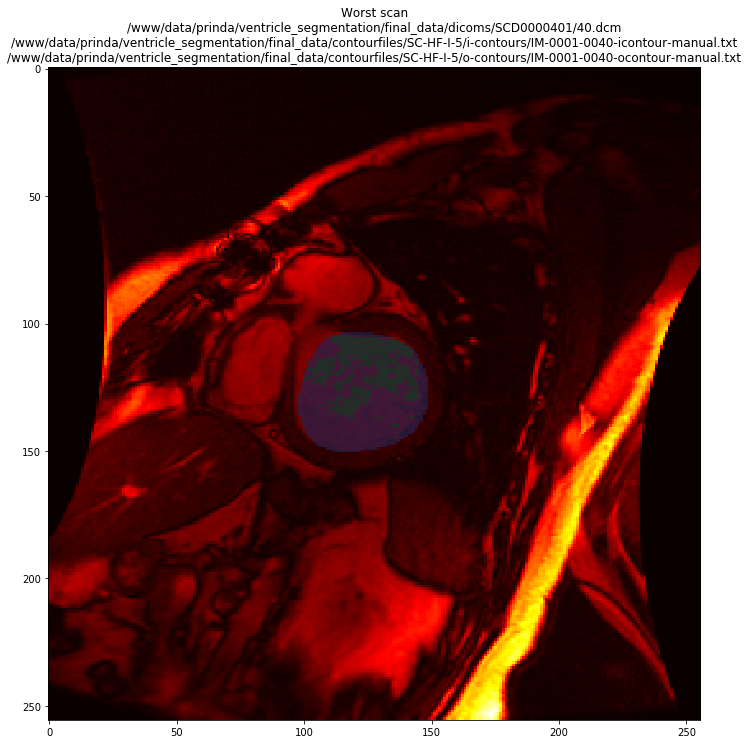

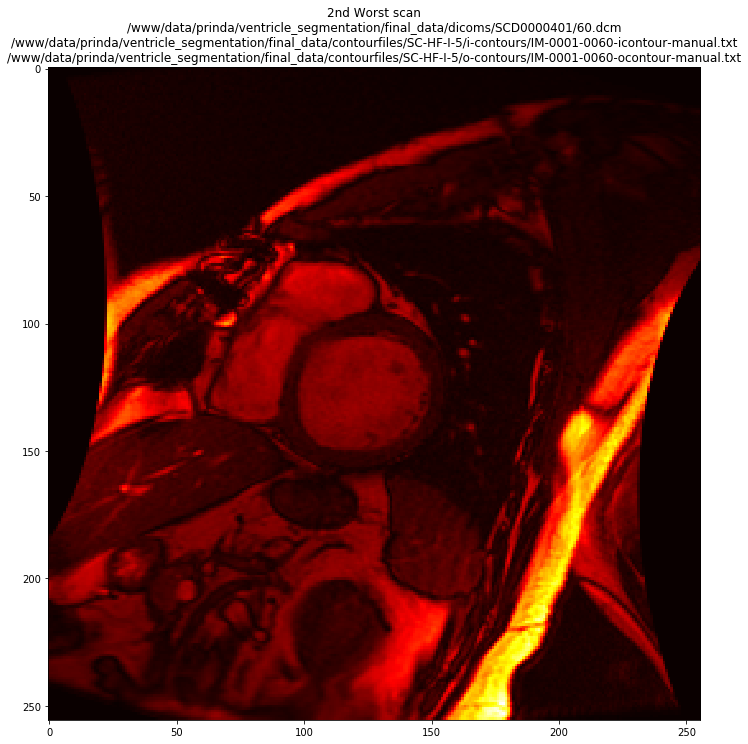

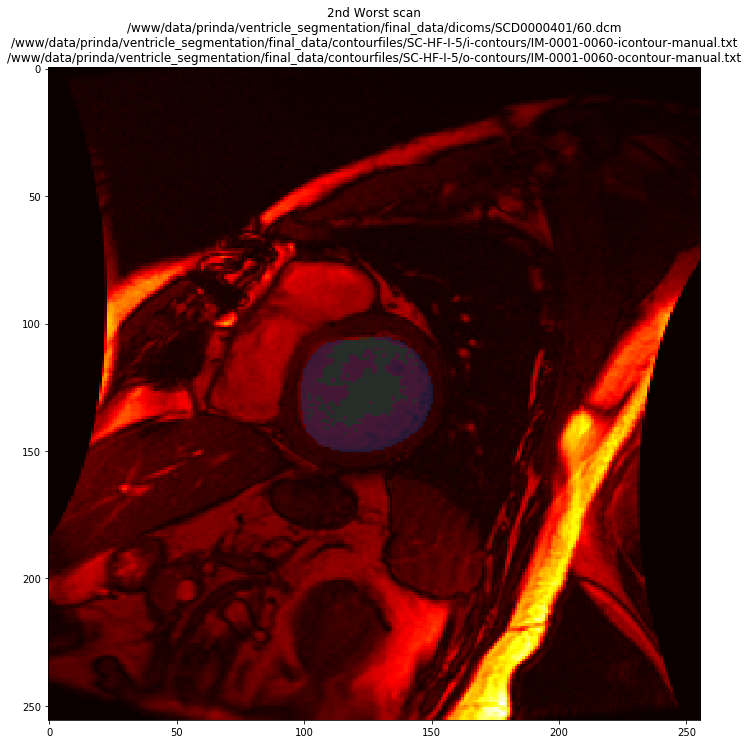

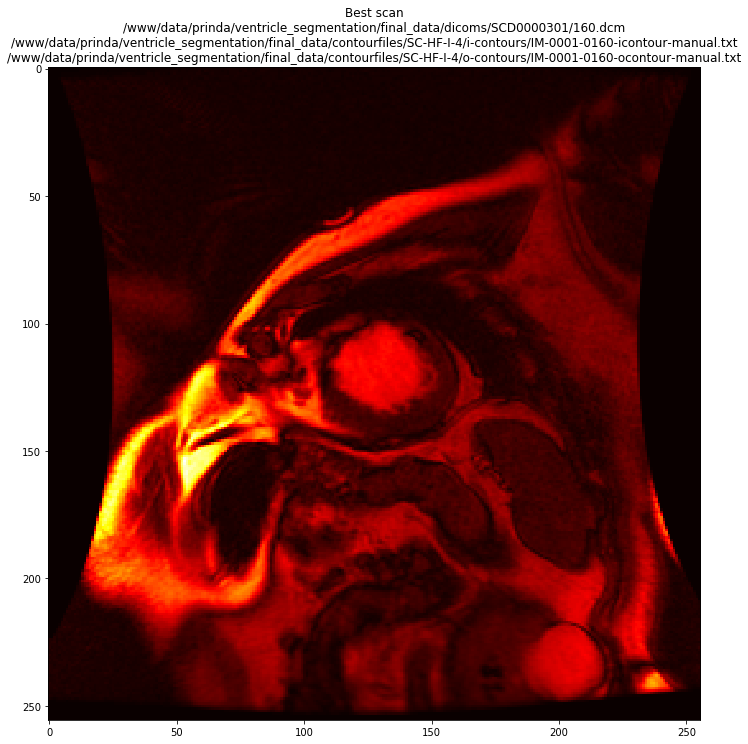

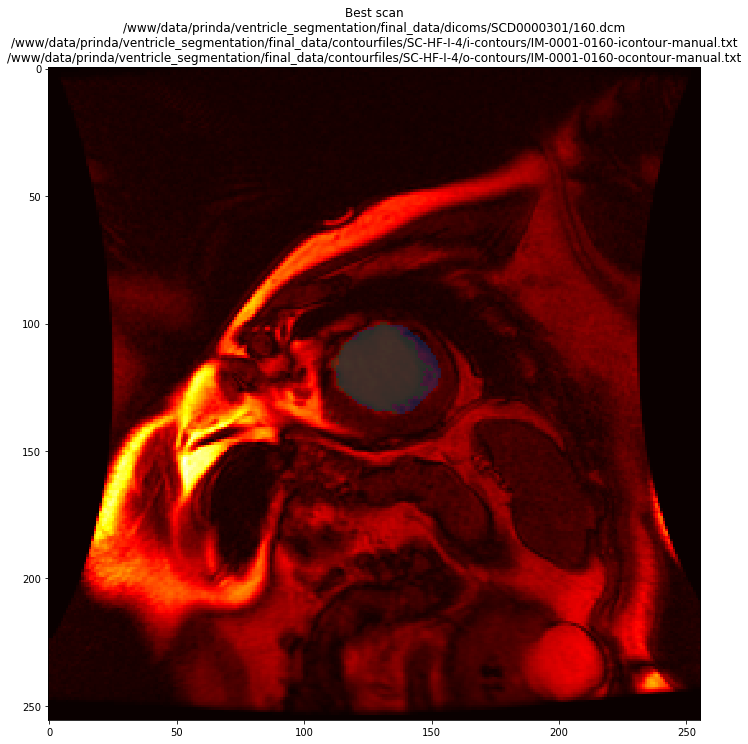

In [7]:
def thresholding_simple(scan, th):
    return (scan.dicom_img > th) & scan.omask.mask
    
th_from_graph = 150

scans_th_simple = copy.deepcopy(scans_test)
scores_simple_th = measure_method(scans_th_simple, thresholding_simple, th=th_from_graph)

The mean iou score of 0.60 is very low. We can see that segmentations for worst images perform very poorly, doesn't preserve shape of a blood pool and are not solid. Which is not a surprise.

## Thresholding normed

Mean score:  0.8077978200743116


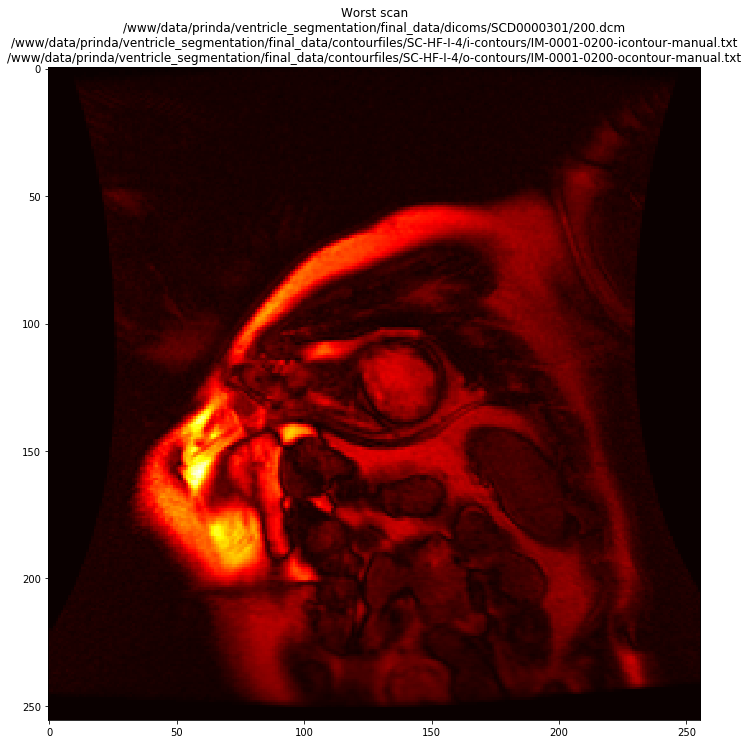

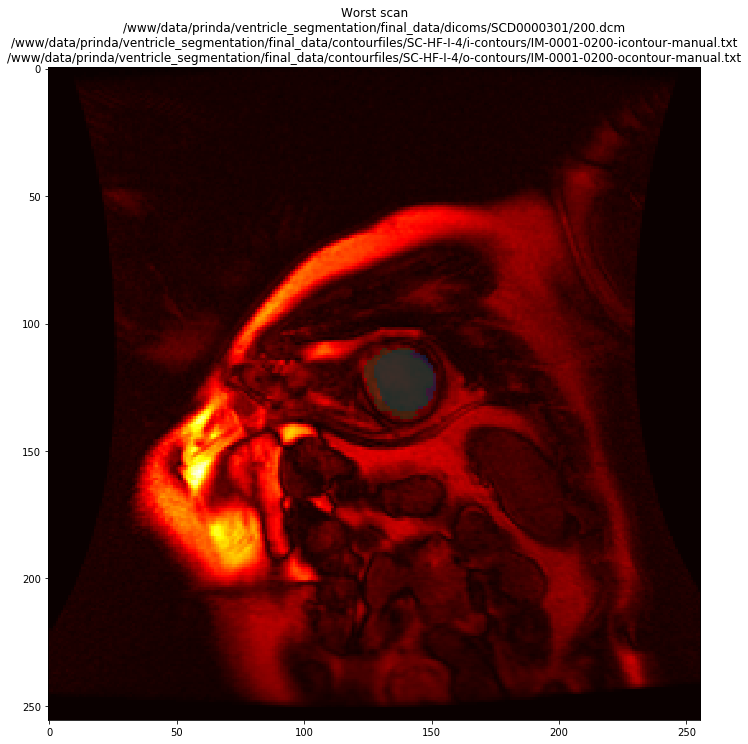

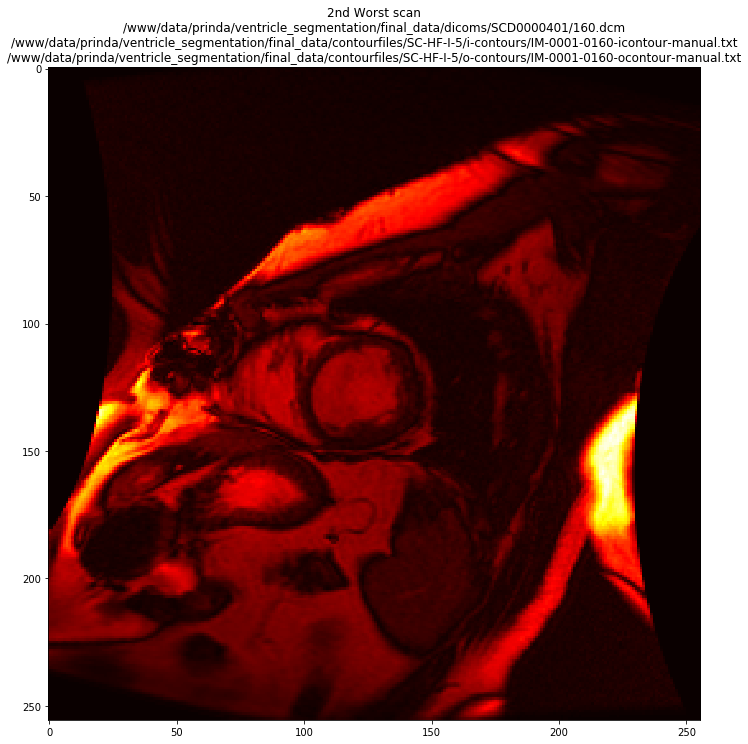

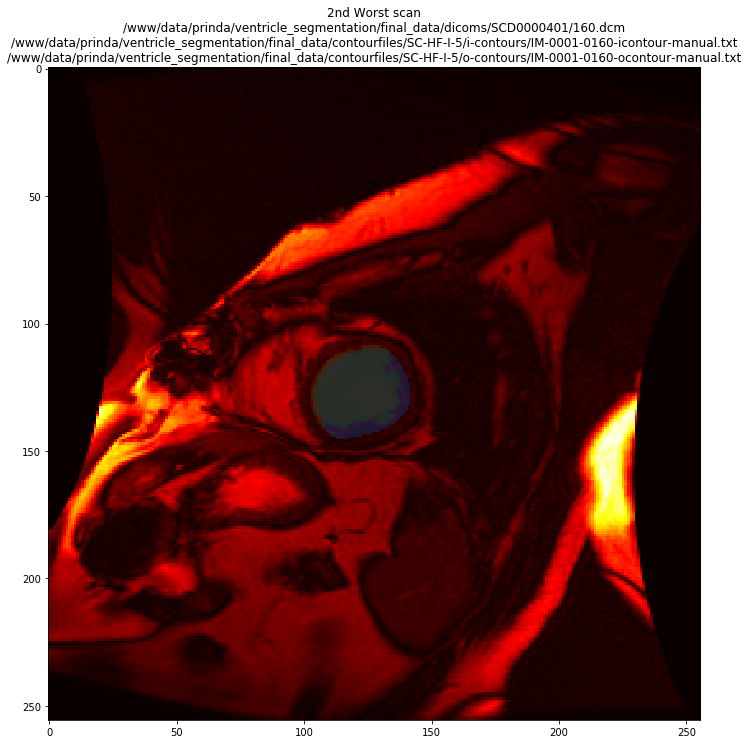

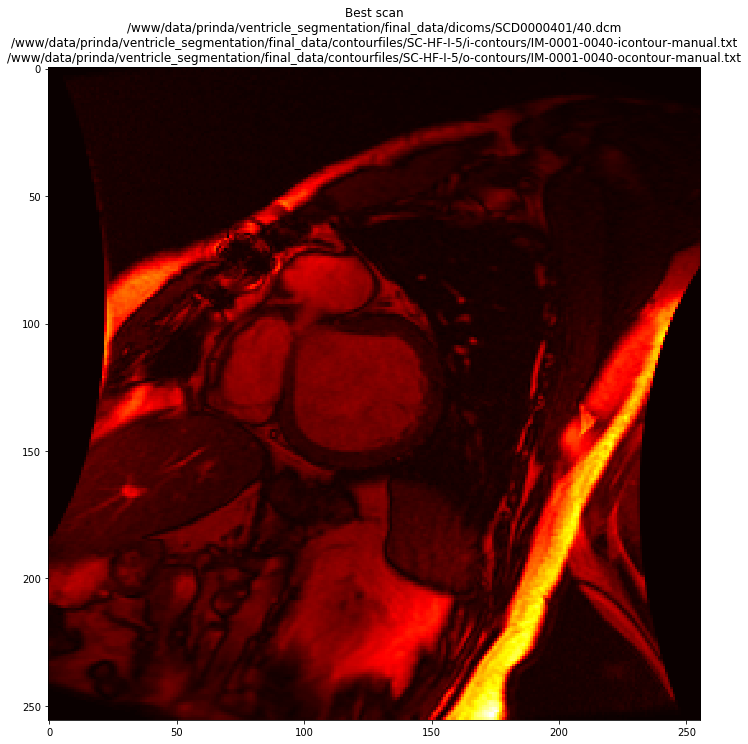

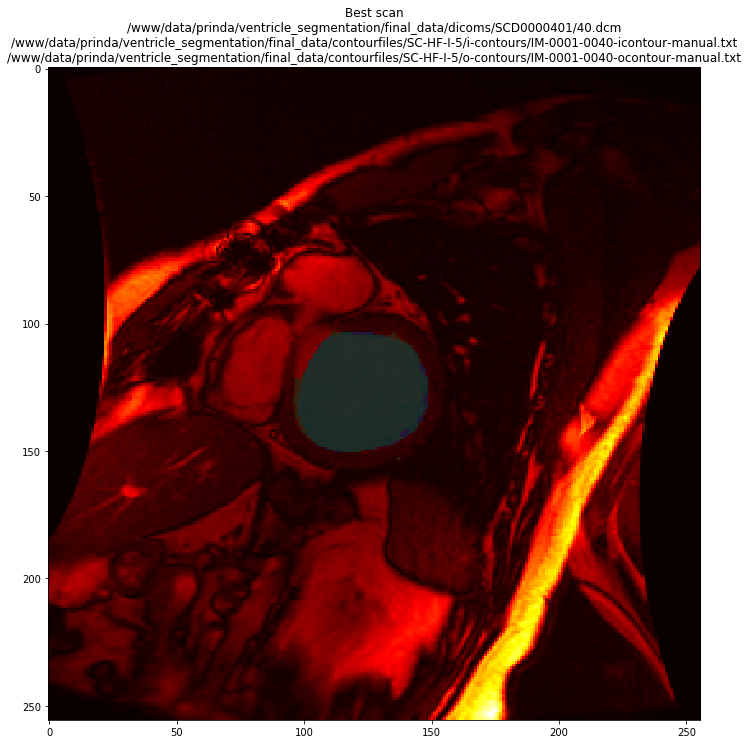

In [8]:
def thresholding_normed(scan, th):
    
    dicom_img = scan.dicom_img.astype(float)
    dicom_img -= dicom_img[scan.omask.mask].min()
    dicom_img /= dicom_img[scan.omask.mask].max()
    
    return (dicom_img > th) & scan.omask.mask
    
th_from_graph = 0.43
scans_th_normed = copy.deepcopy(scans_test)
scores_th_normed = measure_method(scans_th_normed, thresholding_normed, th=th_from_graph)

We can see that mean score incresed to 0.80. Even the worst results are reasonable. The segmentation is quite solid excepts edges of some images. It could be improved with closing (image morphology). 

# Plot thresholding results

Text(0.5,1,'HistOgram iou scores for different thresholding methods')

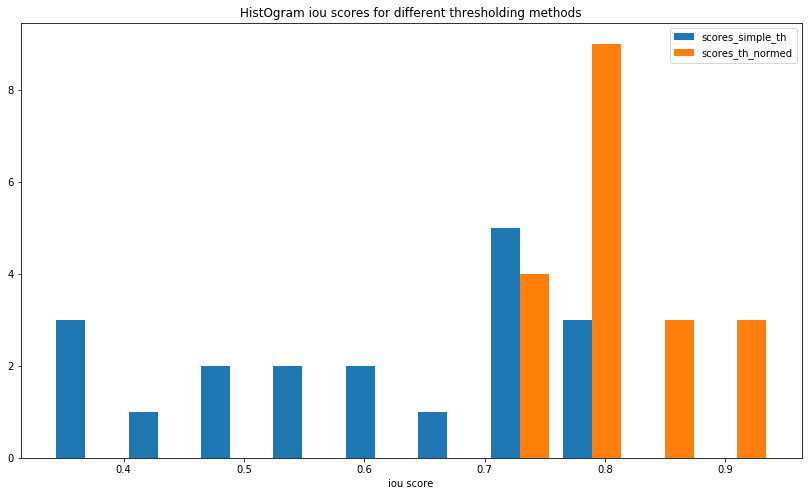

In [9]:
plt.figure(figsize=(14, 8))
plt.hist([scores_simple_th, scores_th_normed], bins=10)
plt.legend(["scores_simple_th", "scores_th_normed"])
plt.xlabel("iou score")
plt.title("HistOgram iou scores for different thresholding methods")

In [10]:
from scipy import stats
stats.ttest_ind(scores_simple_th, scores_th_normed, equal_var=False)

Ttest_indResult(statistic=-5.457940712271355, pvalue=1.3754021693447002e-05)

# Conclusion

From the calculated statistics we can say thresholding of i-contours for normed images inside the o-contours performs significantly better then simple thresholding.

More precise threshold could be found by calculating iou score on scans_dev for all possible thresholds and then pick a threshold with the highest score. Then evaluate it on scans_test to avoid the data leak.

I think thresholding could be used as some baseline method for experimentation but I think some other methods with better performance should be used pro production purposes. It depends on desired performace. Better method example ENet architecture as used in [1] or other types of convolutional networks for semantic segmentation like FCN (Fully convolutional networks). 

From non machine learning approaches for example active contours method [2] could be used. It could perform better due to preserving the shape of a blood pool. The results should be more solid than thresholding. But as stated in [1], active contours performs poorly on low contrast images and are sensitive to hyperparameters. Machine learning would probably be the best way to solve the problem.


[1] FastVentricle: Cardiac Segmentation with ENet. Jesse Lieman-Sifry , Matthieu Le, Felix Lau, Sean Sall, and Daniel Golden

[2] Snakes: Active contour models. Kass, M.; Witkin, A.; Terzopoulos, D. International Journal of Computer Vision 1 (4): 321 (1988).